In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import os

# Ruta al directorio con las imágenes
directorio_imagenes = '/content/drive/My Drive/Proyecto de Grado G/ProcessedImages_Disc_Exp2'

imagenes_info = []
for filename in os.listdir(directorio_imagenes):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        base = filename.split('_')[0]
        id_paciente = base[3:-2]  # Extrae correctamente el ID del paciente
        tipo_ojo = base[-2:]
        full_path = os.path.join(directorio_imagenes, filename)
        imagenes_info.append({'filename': full_path, 'id': id_paciente, 'eye': tipo_ojo})

imagenes_df = pd.DataFrame(imagenes_info)

# Cargar y preparar los datos clínicos
data_od = pd.read_excel('/content/drive/My Drive/Proyecto de Grado G/patient_data_od.xlsx')
data_os = pd.read_excel('/content/drive/My Drive/Proyecto de Grado G/patient_data_os.xlsx')

data_od['id'] = data_od['Unnamed: 0'].str.replace('#', '').astype(str)
data_os['id'] = data_os['Unnamed: 0'].str.replace('#', '').astype(str)

data_od['eye'] = 'OD'
data_os['eye'] = 'OS'

data_clinica = pd.concat([data_od[['id', 'eye', 'Diagnosis']], data_os[['id', 'eye', 'Diagnosis']]])

full_df = pd.merge(imagenes_df, data_clinica, on=['id', 'eye'], how='left')
full_df = full_df[full_df['Diagnosis'] != 2]  # Asume que quieres excluir los diagnósticos '2'

# Ahora necesitamos preparar los datos para un split estratificado
# Primero, determina la "etiqueta" dominante para cada paciente
dominant_diagnosis = full_df.groupby('id')['Diagnosis'].agg(lambda x: x.mode()[0])

# Crea el dataframe para el split estratificado
patient_df = pd.DataFrame(dominant_diagnosis).reset_index()

# Stratified split en los pacientes
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_patients, test_patients = next(splitter.split(patient_df, patient_df['Diagnosis']))

# Obtén los ID de pacientes para cada conjunto
train_ids = patient_df.iloc[train_patients]['id']
test_ids = patient_df.iloc[test_patients]['id']

# Finalmente, selecciona las filas correspondientes en full_df
train_df = full_df[full_df['id'].isin(train_ids)]
test_df = full_df[full_df['id'].isin(test_ids)]

print("Train DataFrame:")
print(train_df[['filename', 'id', 'eye', 'Diagnosis']].head())

print("\nTest DataFrame:")
print(test_df[['filename', 'id', 'eye', 'Diagnosis']].head())

Train DataFrame:
                                             filename   id eye Diagnosis
2   /content/drive/My Drive/Proyecto de Grado G/Pr...  004  OD         1
3   /content/drive/My Drive/Proyecto de Grado G/Pr...  004  OS         1
4   /content/drive/My Drive/Proyecto de Grado G/Pr...  005  OD         1
5   /content/drive/My Drive/Proyecto de Grado G/Pr...  005  OS         1
14  /content/drive/My Drive/Proyecto de Grado G/Pr...  010  OD         1

Test DataFrame:
                                             filename   id eye Diagnosis
20  /content/drive/My Drive/Proyecto de Grado G/Pr...  015  OD         1
21  /content/drive/My Drive/Proyecto de Grado G/Pr...  015  OS         1
32  /content/drive/My Drive/Proyecto de Grado G/Pr...  023  OD         1
33  /content/drive/My Drive/Proyecto de Grado G/Pr...  023  OS         1
42  /content/drive/My Drive/Proyecto de Grado G/Pr...  028  OD         0


In [3]:
import pandas as pd
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.densenet  import DenseNet121, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_auc_score

In [4]:
from sklearn.utils.class_weight import compute_class_weight

# Calcular los pesos de clases
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['Diagnosis']),
    y=train_df['Diagnosis'].astype(int)
)
class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)

Class weights: {0: 0.6320754716981132, 1: 2.392857142857143}


In [5]:
# Configuración del modelo
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    validation_split = 0.2
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

train_b_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [7]:
# Cambiar el tipo de 'Diagnosis' a string usando .loc para evitar SettingWithCopyWarning
train_df.loc[:, 'Diagnosis'] = train_df['Diagnosis'].astype(str)
test_df.loc[:, 'Diagnosis'] = test_df['Diagnosis'].astype(str)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='Diagnosis',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    subset='training'
)

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='Diagnosis',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    subset='validation'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='Diagnosis',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

train_b_generator = train_b_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='Diagnosis',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 268 validated image filenames belonging to 2 classes.
Found 67 validated image filenames belonging to 2 classes.
Found 84 validated image filenames belonging to 2 classes.
Found 335 validated image filenames belonging to 2 classes.


In [8]:
# Calentamiento del modelo con pesos de clase
checkpoint_path = "best_model_warmup.keras"
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor="val_loss", mode='min', verbose=1)

In [9]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    class_weight=class_weights,
    callbacks=[checkpoint],
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.4860
Epoch 1: val_loss improved from inf to 1.08659, saving model to best_model_warmup.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 61s 4s/step - loss: 0.4824 - val_loss: 1.0866
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.3874
Epoch 2: val_loss did not improve from 1.08659
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 307ms/step - loss: 0.3884 - val_loss: 1.1342
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.3292
Epoch 3: val_loss improved from 1.08659 to 0.98433, saving model to best_model_warmup.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 363ms/step - loss: 0.3332 - val_loss: 0.9843
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.3495
Epoch 4: val_loss did not improve from 0.98433
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step - loss: 0.3494 - val_loss: 1.2485
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.3314
Epoch 5: val_loss did not improve from 0.98433
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 420ms/step - loss: 0.3332 - val_loss: 1.2958
Ep

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model.load_weights("best_model_warmup.keras")

for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.00000001), loss='binary_crossentropy')

# Entrenar el modelo durante el fine-tuning
checkpoint_finetune_path = "best_model_finetune.keras"
checkpoint_finetune = ModelCheckpoint(
    checkpoint_finetune_path,
    save_best_only=True,
    monitor="val_loss",
    mode='min',
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

# Fine-tuning del modelo
history_finetune = model.fit(
    train_generator,
    epochs=200,
    validation_data=valid_generator,
    class_weight=class_weights,
    callbacks=[checkpoint_finetune, early_stopping],
)

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: 0.5169 
Epoch 1: val_loss improved from inf to 1.01129, saving model to best_model_finetune.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 270s 14s/step - loss: 0.5168 - val_loss: 1.0113
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 0.5079
Epoch 2: val_loss improved from 1.01129 to 1.00087, saving model to best_model_finetune.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 612ms/step - loss: 0.5097 - val_loss: 1.0009
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.5230
Epoch 3: val_loss improved from 1.00087 to 0.99810, saving model to best_model_finetune.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 643ms/step - loss: 0.5233 - val_loss: 0.9981
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.5181
Epoch 4: val_loss improved from 0.99810 to 0.91507, saving model to best_model_finetune.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 812ms/step - loss: 0.5184 - val_loss: 0.9151
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.5412
Epoch

In [11]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt

predictions_test = model.predict(test_generator, verbose=1)
y_test = test_generator.classes


thresholds = np.arange(0.1, 1.0, 0.1)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    predicted_classes_test = (predictions_test >= threshold).astype(int)
    f1 = f1_score(y_test, predicted_classes_test)
    precision = precision_score(y_test, predicted_classes_test)
    recall = recall_score(y_test, predicted_classes_test)

    print(f'Threshold: {threshold:.2f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}\n')


    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f'Mejor threshold: {best_threshold} con F1 Score: {best_f1}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step
Threshold: 0.10
Precision: 0.2024, Recall: 1.0000, F1 Score: 0.3366

Threshold: 0.20
Precision: 0.1951, Recall: 0.9412, F1 Score: 0.3232

Threshold: 0.30
Precision: 0.1795, Recall: 0.8235, F1 Score: 0.2947

Threshold: 0.40
Precision: 0.1552, Recall: 0.5294, F1 Score: 0.2400

Threshold: 0.50
Precision: 0.2121, Recall: 0.4118, F1 Score: 0.2800

Threshold: 0.60
Precision: 0.2667, Recall: 0.2353, F1 Score: 0.2500

Threshold: 0.70
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000

Threshold: 0.80
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000

Threshold: 0.90
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000

Mejor threshold: 0.1 con F1 Score: 0.33663366336633666


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


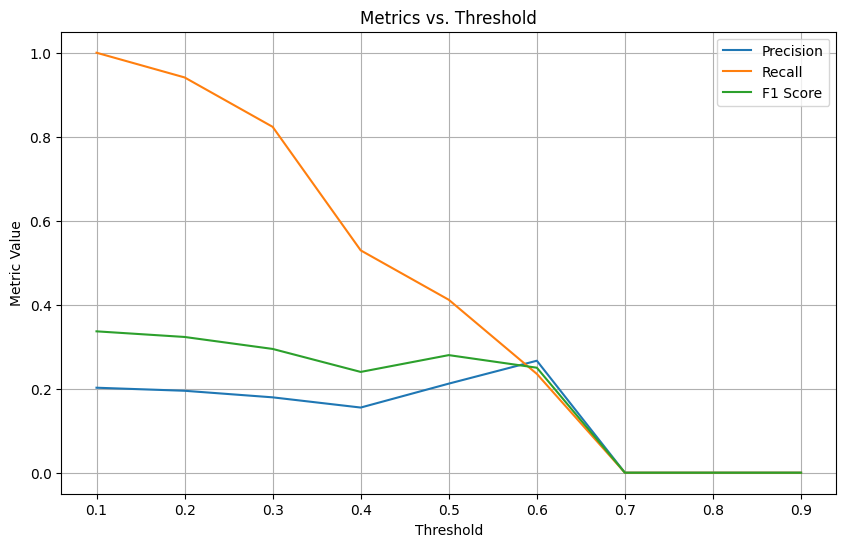

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Inicializar listas para almacenar las métricas
precisions = []
recalls = []
f1_scores = []

# Iterar sobre diferentes thresholds y calcular las métricas
for threshold in thresholds:
    predicted_classes_test = (predictions_test >= threshold).astype(int)
    precisions.append(precision_score(y_test, predicted_classes_test))
    recalls.append(recall_score(y_test, predicted_classes_test))
    f1_scores.append(f1_score(y_test, predicted_classes_test))

# Graficar las métricas en función de los thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Metrics vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# Evaluar con el mejor threshold encontrado
predicted_classes_test = (predictions_test >= best_threshold).astype(int)
print("Test set classification report with custom threshold:")
print(classification_report(y_test, predicted_classes_test, target_names=['Clase 0', 'Clase 1']))

precision = precision_score(y_test, predicted_classes_test)
recall = recall_score(y_test, predicted_classes_test)

print("Precision (Test Set, Class 1) with custom threshold:", precision)
print("Recall (Test Set, Class 1) with custom threshold:", recall)

auc_score_test = roc_auc_score(y_test, predictions_test)
print("Test set AUC Score:", auc_score_test)


Test set classification report with custom threshold:
              precision    recall  f1-score   support

     Clase 0       0.00      0.00      0.00        67
     Clase 1       0.20      1.00      0.34        17

    accuracy                           0.20        84
   macro avg       0.10      0.50      0.17        84
weighted avg       0.04      0.20      0.07        84

Precision (Test Set, Class 1) with custom threshold: 0.20238095238095238
Recall (Test Set, Class 1) with custom threshold: 1.0
Test set AUC Score: 0.4214223002633889


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


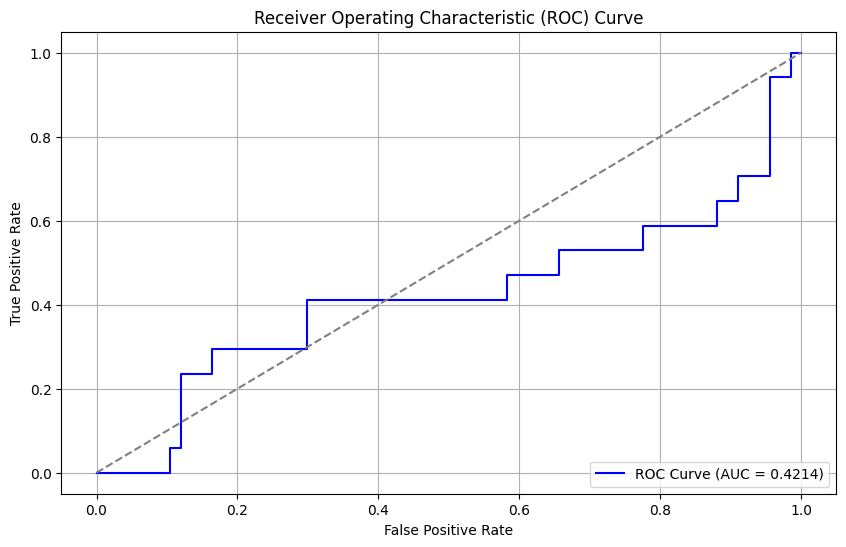

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, predictions_test)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


#RESULTADOS ANTERIORES

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

predictions_test = model.predict(test_generator)
predicted_classes_test = np.round(predictions_test).astype(int)

y_test = test_generator.classes

print("Test set classification report after warmup:")
print(classification_report(y_test, predicted_classes_test, target_names=['Clase 0', 'Clase 1']))
auc_score_test = roc_auc_score(y_test, predictions_test)
print("Test set AUC Score after warmup:", auc_score_test)

predictions_train = model.predict(train_b_generator, steps=len(train_b_generator), verbose=1)
predicted_classes_train = np.round(predictions_train).astype(int)

y_train = train_b_generator.classes

print("Train set classification report after warmup:")
print(classification_report(y_train, predicted_classes_train, target_names=['Clase 0', 'Clase 1']))
auc_score_train = roc_auc_score(y_train, predictions_train)
print("Train set AUC Score after warmup:", auc_score_train)

3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 7s/step
Test set classification report after warmup:
              precision    recall  f1-score   support

     Clase 0       0.79      0.88      0.83        67
     Clase 1       0.11      0.06      0.08        17

    accuracy                           0.71        84
   macro avg       0.45      0.47      0.45        84
weighted avg       0.65      0.71      0.68        84

Test set AUC Score after warmup: 0.6057945566286216
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Train set classification report after warmup:
              precision    recall  f1-score   support

     Clase 0       0.86      0.95      0.90       265
     Clase 1       0.70      0.40      0.51        70

    accuracy                           0.84       335
   macro avg       0.78      0.68      0.71       335
weighted avg       0.82      0.84      0.82       335

Train set AUC Score after warmup: 0.7842048517520215


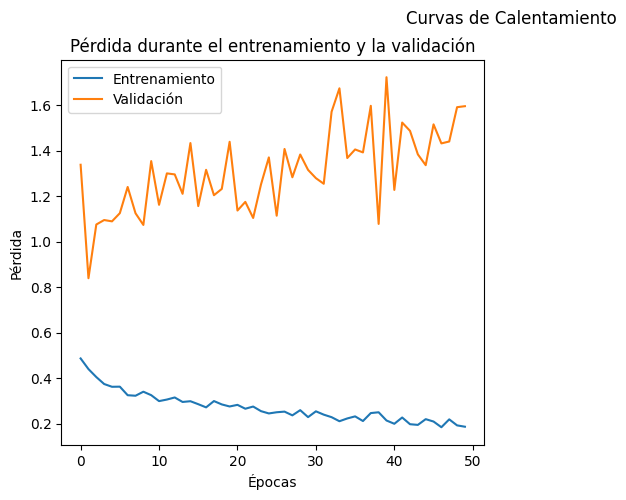

In [ ]:
def plot_training_curves(history, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Pérdida durante el entrenamiento y la validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.suptitle(title)
    plt.show()

plot_training_curves(history, 'Curvas de Calentamiento')

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

# Evaluación del modelo en el conjunto de validación (test_generator) después del calentamiento
predictions_test = model.predict(test_generator)
predicted_classes_test = np.round(predictions_test).astype(int)

y_test = test_generator.classes

print("Test set classification report after fine-tuning:")
print(classification_report(y_test, predicted_classes_test, target_names=['Clase 0', 'Clase 1']))
auc_score_test = roc_auc_score(y_test, predictions_test)
print("Test set AUC Score after fine-tuning:", auc_score_test)

predictions_train = model.predict(train_b_generator, steps=len(train_b_generator), verbose=1)
predicted_classes_train = np.round(predictions_train).astype(int)


y_train = train_b_generator.classes

print("Train set classification report after fine-tuning:")
print(classification_report(y_train, predicted_classes_train, target_names=['Clase 0', 'Clase 1']))
auc_score_train = roc_auc_score(y_train, predictions_train)
print("Train set AUC Score after fine-tuning:", auc_score_train)

3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step
Test set classification report after fine-tuning:
              precision    recall  f1-score   support

     Clase 0       0.82      0.91      0.87        67
     Clase 1       0.40      0.24      0.30        17

    accuracy                           0.77        84
   macro avg       0.61      0.57      0.58        84
weighted avg       0.74      0.77      0.75        84

Test set AUC Score after fine-tuning: 0.47497805092186135
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 479ms/step
Train set classification report after fine-tuning:
              precision    recall  f1-score   support

     Clase 0       0.80      0.80      0.80       265
     Clase 1       0.24      0.23      0.23        70

    accuracy                           0.68       335
   macro avg       0.52      0.52      0.52       335
weighted avg       0.68      0.68      0.68       335

Train set AUC Score after fine-tuning: 0.5852830188679244


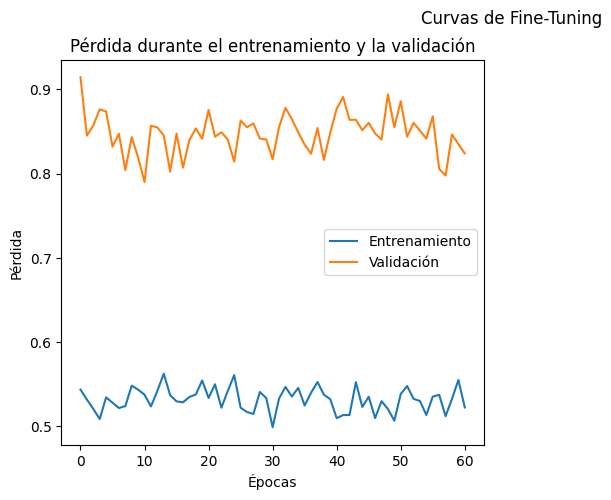

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(history, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Pérdida durante el entrenamiento y la validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.suptitle(title)
    plt.show()


plot_training_curves(history_finetune, 'Curvas de Fine-Tuning')


In [ ]:
from sklearn.metrics import precision_score, recall_score

predictions_test = model.predict(test_generator)
predicted_classes_test = np.round(predictions_test).astype(int)
y_test = test_generator.classes

precision = precision_score(y_test, predicted_classes_test, average='binary', pos_label=1)
recall = recall_score(y_test, predicted_classes_test, average='binary', pos_label=1)

print("Precision (Test Set, Class 1):", precision)
print("Recall (Test Set, Class 1):", recall)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
Precision (Test Set, Class 1): 0.4
Recall (Test Set, Class 1): 0.23529411764705882


In [ ]:
import pandas as pd

# Conteo de samples por clase en el conjunto de entrenamiento
train_class_counts = pd.Series(y_train).value_counts().sort_index()

# Conteo de samples por clase en el conjunto de prueba
test_class_counts = pd.Series(y_test).value_counts().sort_index()

# Crear un DataFrame con los resultados
class_counts_df = pd.DataFrame({
    'Clase': ['Clase 0', 'Clase 1'],
    'Samples (Train)': [train_class_counts.get(0, 0), train_class_counts.get(1, 0)],
    'Samples (Test)': [test_class_counts.get(0, 0), test_class_counts.get(1, 0)]
})

# Mostrar el DataFrame
print("Number of Samples per Class in Train and Test Sets:")
print(class_counts_df)


Number of Samples per Class in Train and Test Sets:
     Clase  Samples (Train)  Samples (Test)
0  Clase 0              265              67
1  Clase 1               70              17
